ابتدا با استفاده از دیتای داده شده هر کدام از ژن‌ها را بدست می‌آوریم و در یک دیکشنری میریزیم

In [1]:
def make_genes_dictionary(genes_path):
    #read genes file and splite by \n 
    inf = open(genes_path, "r")
    input = inf.read()
    lines = input.split("\n")

    RNA = ""
    gene_name = ""
    gene_list = []
    dictionary = dict()
    #clean string 
    if lines[0].startswith(">"):
        gene_name = lines[0].replace(">", "").replace("\r", "")

    for line in lines:
        line = line.replace('\r', "")
        #if we see > in first of string, means that one gene finish and another is start
        if line.startswith(">") or line.__len__() == 0:
            if RNA.__len__() > 1:
                dictionary[gene_name] = RNA
                gene_list.append(gene_name)
                gene_name = line.replace(">", "")
            RNA = ""
        else:
            RNA = RNA + line
    return dictionary, gene_list

genes_path = "BioProjectFiles/Marburg_Genes.fasta"
genes_dictionary, gene_list = make_genes_dictionary(genes_path)

در این قسمت تمام ژنوم‌ها را میخوانیم و با استفاده از تابع هم‌ترازی جایگاه تمام ژن‌ها را بدست می‌آوریم و برای هرکدام در دیکشنری مخصوص خود را میسازیم 

In [2]:
def alignment(gene, genome, start_genome):
    n = len(genome)
    m = len(gene)
    
    #first set dp to INF because we want to minimize dp
    dp = [[10000000000 for _ in range(m + 1)] for _ in range(n + 1)]
    parent = [[0 for _ in range(m + 1)] for _ in range(n + 1)]
    
    #for first step dp[i][0] = 0 becuase we want to use global alignmet and for the begining gap the score is 0  
    for i in range(n):
        dp[i][0] = 0
        parent[i][0] = i

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cur = 1
            if genome[i - 1] == gene[j - 1]:
                cur = 0
            if dp[i - 1][j - 1] + cur < dp[i][j]:
                dp[i][j] = dp[i - 1][j - 1] + cur
                parent[i][j] = parent[i - 1][j - 1]
            if dp[i - 1][j] + 1 < dp[i][j]:
                dp[i][j] = dp[i - 1][j] + 1
                parent[i][j] = parent[i - 1][j]
            if dp[i][j - 1] + 1 < dp[i][j]:
                dp[i][j] = dp[i][j - 1] + 1
                parent[i][j] = parent[i][j - 1]

    min1 = 10000000000
    start = 0
    end = 0
    #choose the minimom from d[i][m] becuase for end gap we use 0 score
    for i in range(n):
        if dp[i][m] < min1:
            min1 = dp[i][m]
            start = parent[i][m]
            end = i - 1
    return start + start_genome, end + start_genome

این تابع به این صورت عمل میکند که برای ژن‌های مختلف، قسمت‌هایی که باید در ژنوم به دنبال آن باشیم را پیدا میکند و با 
استفاده از تابع همترازی بالا شروع و پایان یک ژن در ژنوم را بدست می‌آورد.

In [3]:
def full_alignment(genes, genome, gene_list):
    start = 300
    end = 300
    ans = dict()
    for gene_key in gene_list:
        start, end = alignment(genes[gene_key], genome[end - 300:len(genes[gene_key])*2 + end - 300], end - 300)
        ans[gene_key] = (start, end)
    return ans

در این قسمت یک ژنوم را میخوانیم

In [4]:
def read_genome(genome_path):
    inf = open(genome_path, "r")
    input = inf.read()
    lines = input.split("\n")

    RNA = ""

    for line in lines:
        line = line.replace('\r', "")
        if line.startswith(">") or line.__len__() == 0:
            if RNA.__len__() > 1:
                return RNA
        else:
            RNA = RNA + line

تمام ژنوم‌ها را میخوانیم و در یک لیست نگه می‌داریم 

In [5]:
genome_name_list = ['Bundibugyo', 'Reston', 'Sudan', 'TaiForest', 'Zaire']
genome_list = []

full_genome_name_list = ['Bundibugyo', 'Reston', 'Sudan', 'TaiForest', 'Zaire', 'Marburg']
full_genome_list = []

#make genome_list for all genome 
for genome_name in genome_name_list:
    genome_list.append(read_genome("BioProjectFiles/"+ genome_name +"_genome.fasta"))

for genome_name in full_genome_name_list:
    full_genome_list.append(read_genome("BioProjectFiles/"+ genome_name +"_genome.fasta"))

genome_dict_list = []
for genome in genome_list:
    genome_dict_list.append(full_alignment(genes_dictionary, genome, gene_list))

قسمت هایی از ژنوم‌های گونه های مختلف که ژن یکسان هستند را در یک فایل به نام همان ژن ذخیره میکنیم

In [6]:
def save_gene(genes, genome):
    for gene_name, list in zip(genes.keys(), genes.values()):
        file = open('gene/' + gene_name, 'a')
        #in list we save start and end of gene in genome and we save every gene of all genome in same file
        file.write(genome[list[0]:list[1]] + '\n')
        file.close()

In [7]:
for genome_dict, genome in zip(genome_dict_list, genome_list):
    save_gene(genome_dict, genome)

در قسمتی دیگر نیاز به همترازی سراسری ژنوم‌های مختلف است که برای این‌کار از تابع زیر استفاده میکنیم

In [9]:
def global_alignment(gene1, gene2):
    n = len(gene2)
    m = len(gene1)
    dp = [[10000000000 for _ in range(m + 1)] for _ in range(n + 1)]
    
    #we just define d[0][0] = 0 becuase we use global alignment
    dp[0][0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cur = 1
            if gene2[i - 1] == gene1[j - 1]:
                cur = 0
            if dp[i - 1][j - 1] + cur < dp[i][j]:
                dp[i][j] = dp[i - 1][j - 1] + cur
            if dp[i - 1][j] + 1 < dp[i][j]:
                dp[i][j] = dp[i - 1][j] + 1
            if dp[i][j - 1] + 1 < dp[i][j]:
                dp[i][j] = dp[i][j - 1] + 1

    return dp[n][m]

در این قسمت سی اس وی‌های مختلف را ذخیره میکنیم

In [10]:
import csv

def save_csv(gene_name):
    inf = open("gene/" + gene_name, "r")
    input = inf.read()
    lines = input.split("\n")
    with open('csv/'+ gene_name + ".csv", 'wb') as resultFile:
        wr = csv.writer(resultFile, dialect='excel')
        for i in range(len(lines)):
            alignment = []
            for j in range(len(lines)):
                if i == j:
                    alignment.append(0)
                else:
                    alignment.append(global_alignment(lines[i], lines[j]))
            wr.writerow(alignment)

In [11]:
for gene in gene_list:
    save_csv(gene)

برای ساختن درخت زندگی ژن‌هااز تابع زیر استفاده میکنیم

In [12]:
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo import draw
import matplotlib.pyplot as plt


def make_tree(matrix, gene_name, names):
    matrix_tree = DistanceMatrix(names, matrix)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(matrix_tree)
    draw(tree, do_show=False)
    plt.savefig('UPGMA/UPGMA_'+ gene_name +'.png')
    tree = constructor.nj(matrix_tree)
    draw(tree, do_show=False)
    plt.savefig('NJ/NJ_'+ gene_name +'.png')

با استفاده از سی اس وی ‌هایی که ساخته‌ایم یک ماتریس پایین مثلثی میسازیم تا با استفاده از آن بتوانیم درخت زندگی را یسازیم

In [13]:
def read_csv(gene_name):
    matrix = []
    with open('csv/'+ gene_name + ".csv", "rb") as f:
        reader = csv.reader(f)
        i = 0
        for row in reader:
            m = []
            for j in range(0,i+1):
                m.append(int(row[j]))
            matrix.append(m)
            i=i+1
    return matrix

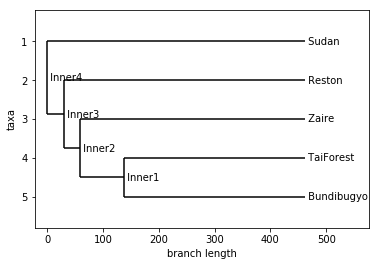

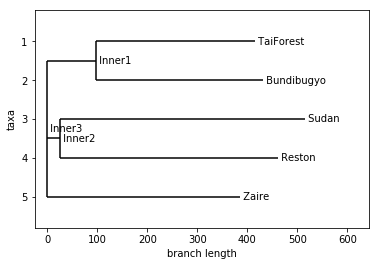

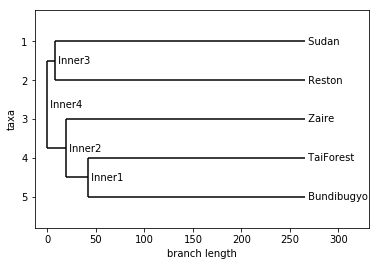

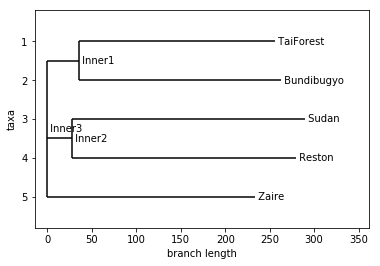

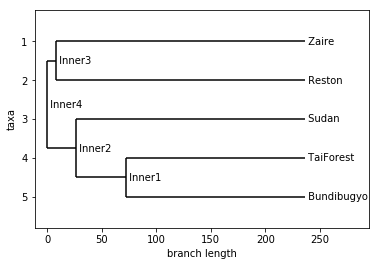

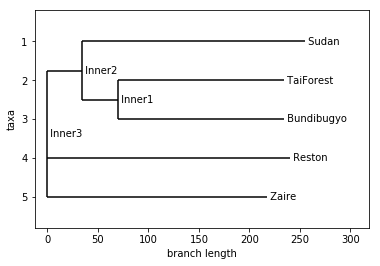

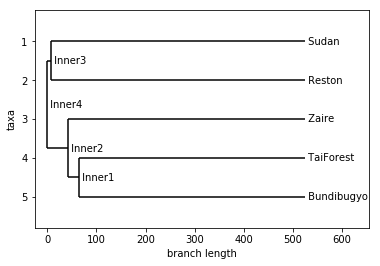

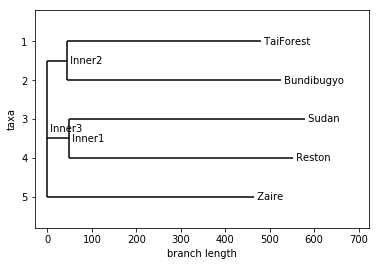

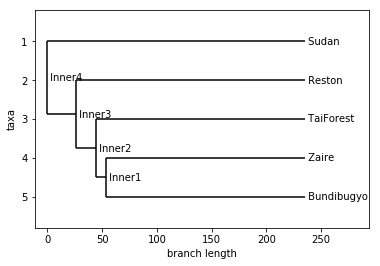

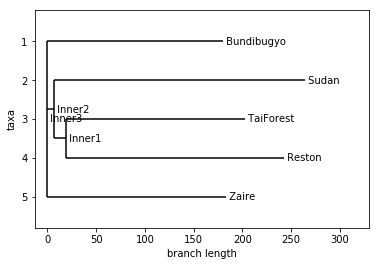

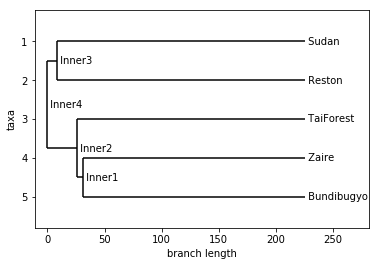

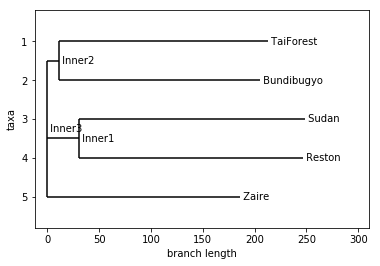

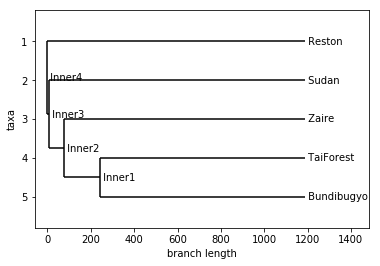

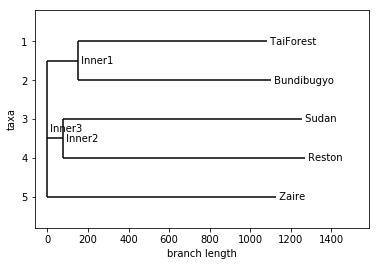

In [14]:
for gene in gene_list:
    make_tree(read_csv(gene), gene, genome_name_list)

برای یک ماتریس باید ماتریس پایین مثلثی آن را بسازیم

In [15]:
def make_tringle_matrix(full_matrix):
    matrix = []
    i = 0
    for row in full_matrix:
        m = []
        for j in range(0,i+1):
            m.append(float(row[j]))
        matrix.append(m)
        i=i+1    
    return matrix

برای ساختن درخت زندگی سراسری ماتریس‌هاس مختلف را باهم جمع کردم

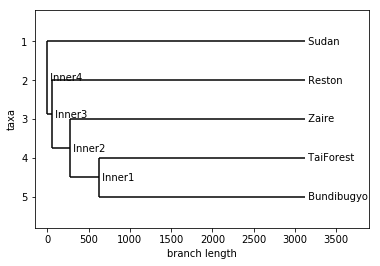

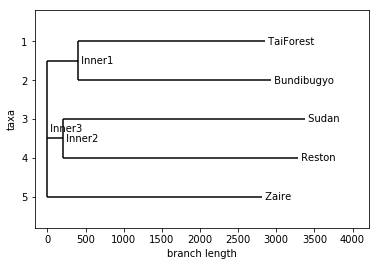

In [17]:
def make_final_tree():
    full_matrix = [[0 for _ in range(5)] for _ in range(5)]
    avrg = 0
    for gene_name in gene_list:
        inf = open("gene/" + gene_name, "r")
        input = inf.read()
        lines = input.split("\n")
        for line in lines:
            avrg = avrg + len(line)
        #read all csv and sum matrix
        with open('csv/'+ gene_name + ".csv", "rb") as f:
            reader = csv.reader(f)
            i = 0
            for row in reader:
                for j in range(0,i+1):
                    full_matrix[i][j] += float(row[j])
                i+=1
    return full_matrix
        

make_tree(make_tringle_matrix(make_final_tree()), "merge", genome_name_list)

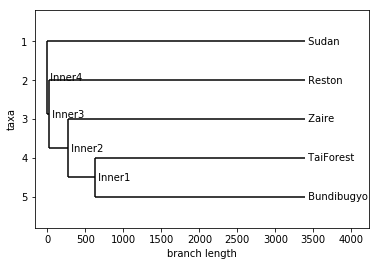

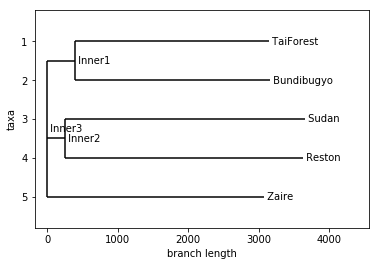

In [18]:
import edlib

def edlib_alignment(genomeList):
    matrix = []
    for genome1 in genomeList:
        m = []
        for genome2 in genomeList:
            m.append(edlib.align(genome1, genome2)['editDistance'])
        matrix.append(m)
    return matrix


make_tree(make_tringle_matrix(edlib_alignment(genome_list)), "global_genome", genome_name_list)

In [ ]:
make_tree(make_tringle_matrix(edlib_alignment(full_genome_list)), "global_genome_with_murberg", full_genome_name_list)

In [39]:
from math import log

def find_distance(a, n):
    alpha = 1e-3 * 1.9
    tmp = 1 - ((4.0 * a)/(3.0 * n))
    t = -1 * (9 * log(tmp))/ (4 * alpha)
    return t


In [65]:
matrix = []
for i in range(len(genome_list)):
    m = []
    for j in range(i):
        if i == j:
            continue
        distance = find_distance(edlib.align(genome_list[i], genome_list[j])['editDistance'], (len(genome_list[i]) + len(genome_list[j]))/2)
        m.append(distance)
        print(genome_name_list[i], genome_name_list[j], distance)
    m.append(0)
    matrix.append(m)

('Reston', 'Bundibugyo', 772.397697222684)
('Sudan', 'Bundibugyo', 775.74926574973)
('Sudan', 'Reston', 772.7989402993136)
('TaiForest', 'Bundibugyo', 584.111465089907)
('TaiForest', 'Reston', 770.2709034273716)
('TaiForest', 'Sudan', 774.0975334084071)
('Zaire', 'Bundibugyo', 685.7094454173945)
('Zaire', 'Reston', 755.9196318696568)
('Zaire', 'Sudan', 763.18453761908)
('Zaire', 'TaiForest', 680.16997388412)


In [66]:
print matrix
matrix_tree = DistanceMatrix(genome_name_list, matrix)
constructor = DistanceTreeConstructor()
tree = constructor.nj(matrix_tree)
tree.common_ancestor(genome_name_list)

[[0], [772.397697222684, 0], [775.74926574973, 772.7989402993136, 0], [584.111465089907, 770.2709034273716, 774.0975334084071, 0], [685.7094454173945, 755.9196318696568, 763.18453761908, 680.16997388412, 0]]


Clade(branch_length=0, name='Inner3')

In [67]:
for name in genome_name_list:
    print "root", name, tree.distance('Inner3', name)

root Bundibugyo 349.811237041
root Reston 422.157111272
root Sudan 427.584113774
root TaiForest 346.705237818
root Zaire 334.681472222
